<a href="https://colab.research.google.com/github/magistery-tps/dm-cyt-tp/blob/main/TP_microestados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# **Instalacion de paquetes**

Bajo paquete para trabajar con EEG- Me permite ver la topografía

In [5]:
!pip install mne

# Descargar dataset

Se descarga el dataset y lo descomprime en `~/dataset`.

In [3]:
filename     = "procesados-20210908T224817Z-001.zip"
dataset_url  =  f'https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp/main/datasets/{filename}'
dataset_path = "dataset"

!cd ~
!rm -rf procesados
!rm -rf dataset
!rm -rf {filename}
!wget  {dataset_url}
!unzip {filename}
!mv procesados dataset

--2021-09-16 01:41:12--  https://raw.githubusercontent.com/magistery-tps/dm-cyt-tp/main/datasets/procesados-20210908T224817Z-001.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7272780 (6.9M) [application/zip]
Saving to: ‘procesados-20210908T224817Z-001.zip’

procesados-20210908 100%[===================>]   6.94M  --.-KB/s    in 0.04s   

2021-09-16 01:41:12 (191 MB/s) - ‘procesados-20210908T224817Z-001.zip’ saved [7272780/7272780]

Archive:  procesados-20210908T224817Z-001.zip
  inflating: procesados/suj_12_bl_2.txt  
  inflating: procesados/suj_8_bl_2.txt  
  inflating: procesados/suj_9_bl_1.txt  
  inflating: procesados/suj_8_bl_1.txt  
  inflating: procesados/suj_12_bl_1.txt  
  inflating: procesados/suj_13_bl_1.txt  
  inflating: procesados/suj_10_b

# **Importa libreria**

In [4]:
!git clone https://github.com/magistery-tps/dm-cyt-tp.git

Cloning into 'dm-cyt-tp'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 54 (delta 16), reused 34 (delta 6), pack-reused 0
Unpacking objects: 100% (54/54), done.


In [19]:
import sys

hostname = !hostname
sys.path.append('./src' if hostname[0] == 'skynet' else '/content/dm-cyt-tp/src')

# **Importa paquetes**

In [48]:
import numpy as np
import pandas as pd
from scipy.signal import butter, lfilter

from scipy.signal import find_peaks
from sklearn.cluster import KMeans

from plot import plot_egg, plot_egg_diff, plot_eeg_topology, plot_eeg_pca, plot_df_pca, plot_GPF
from egg  import get_info_eeg_and_montage, channels

from read_egg  import load_egg, load_eeg_dataset, to_data_frame

El registro de EEG de 30 canales viene en formato txt (cada uno de los canales es una señal de un electrodo). La frecuencia de muestreo es de 256 Hz.

## 1 - Lectura de datos de EEG

Para cada persona identificada con el número que sigue a "suj_" se hicieron dos registros para cada persona, uno antes de aprender algo "bl_1" y el otro despues de aprender algo "bl_2"

In [49]:
eegs = load_eeg_dataset('./dataset/*')

In [50]:
eegs[0].to_dict()

{'subject': '9',
 'resting_state': '1',
 'nchannels': 30,
 'sfrequency': 128,
 'nsamples': 7681,
 'data': array([[ 1.616  , -0.24897,  2.1471 , ..., -0.22272,  4.0591 , -1.7013 ],
        [-1.4653 , -2.1064 ,  1.8991 , ..., -2.5467 ,  7.479  , -4.1234 ],
        [-3.7501 , -3.2131 ,  0.54613, ..., -3.9687 ,  8.9219 , -5.7996 ],
        ...,
        [-8.728  , -9.0875 , -1.7395 , ..., -5.642  ,  5.1158 , -8.1424 ],
        [-7.7983 , -6.0041 ,  1.8113 , ..., -4.8075 ,  4.5658 , -6.6284 ],
        [-3.9895 , -1.6225 ,  5.0169 , ..., -2.4491 ,  1.9292 , -3.6368 ]])}

sujeto: 10 estado de reposo: 1


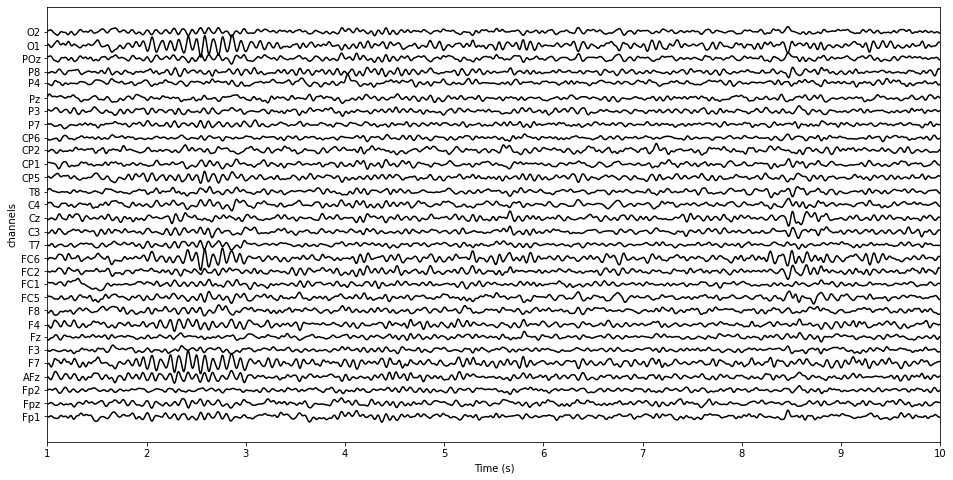

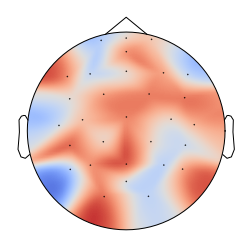

(30, 3)
sujeto: 10 estado de reposo: 2


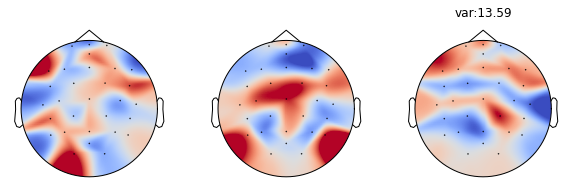

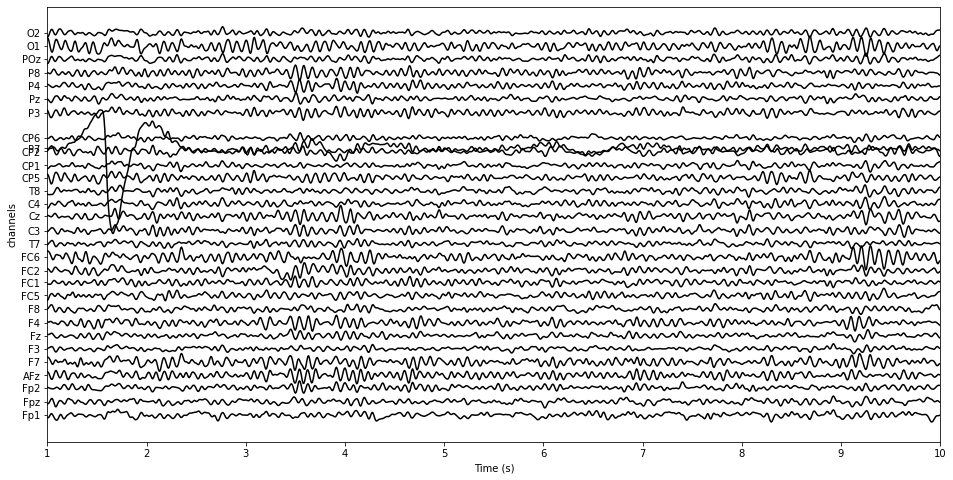

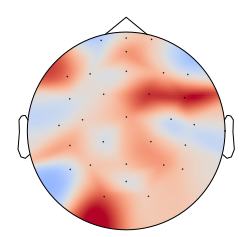

(30, 3)
sujeto: 12 estado de reposo: 1


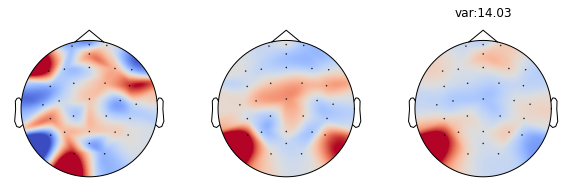

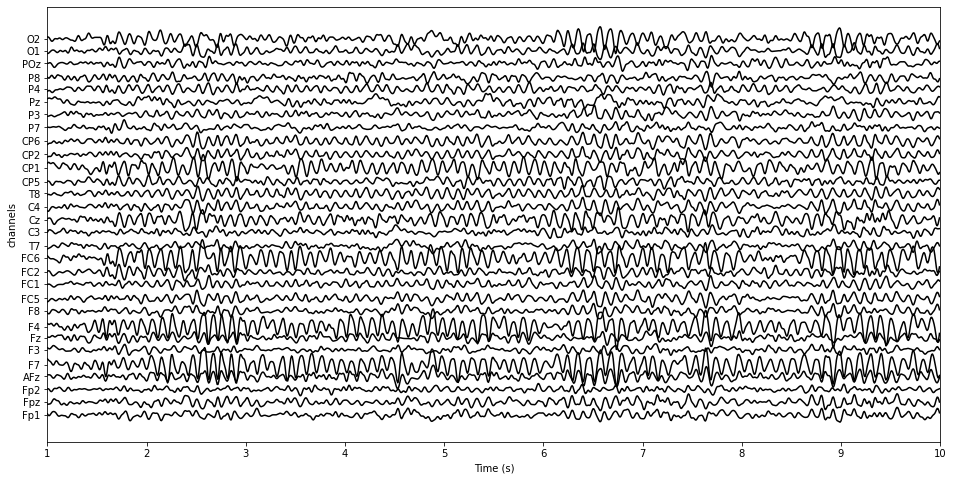

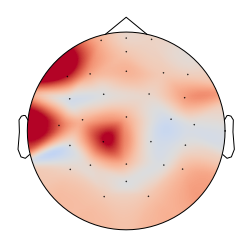

(30, 3)
sujeto: 12 estado de reposo: 2


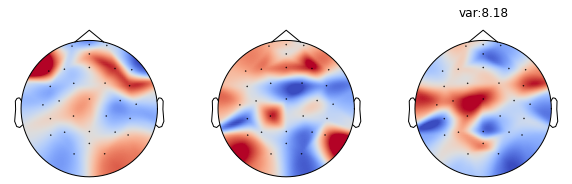

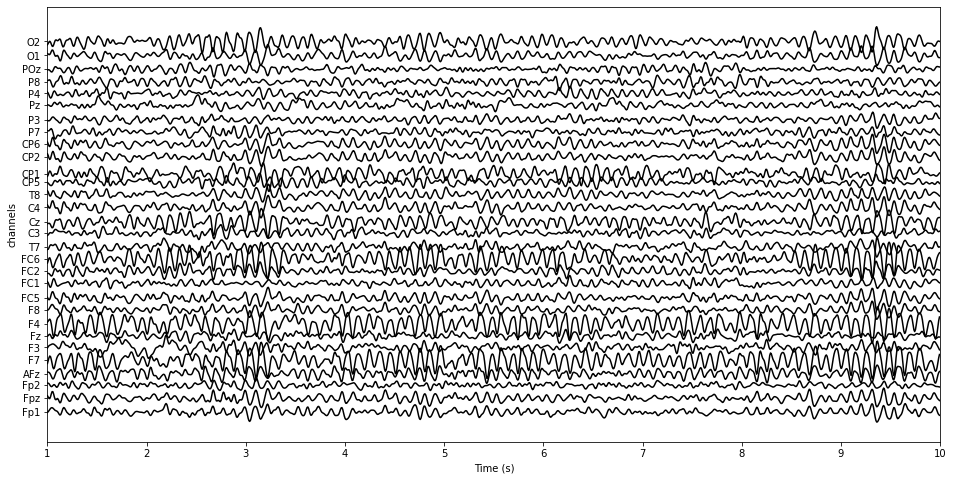

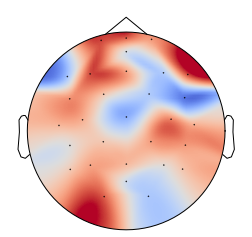

(30, 3)
sujeto: 13 estado de reposo: 1


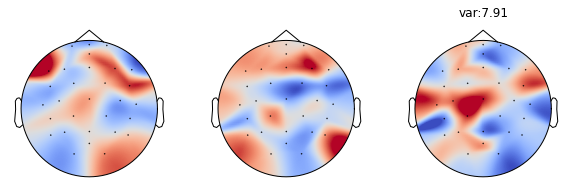

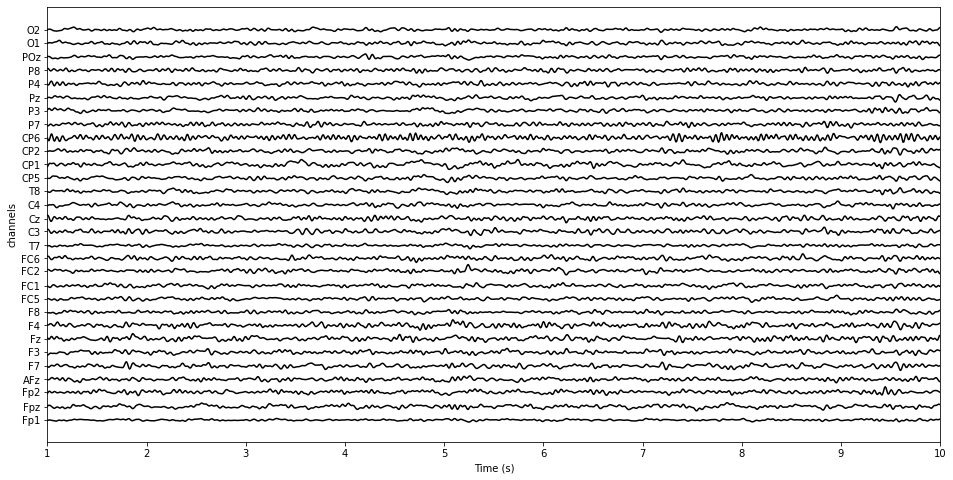

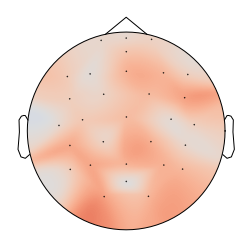

(30, 3)
sujeto: 13 estado de reposo: 2


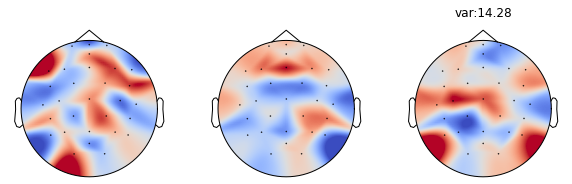

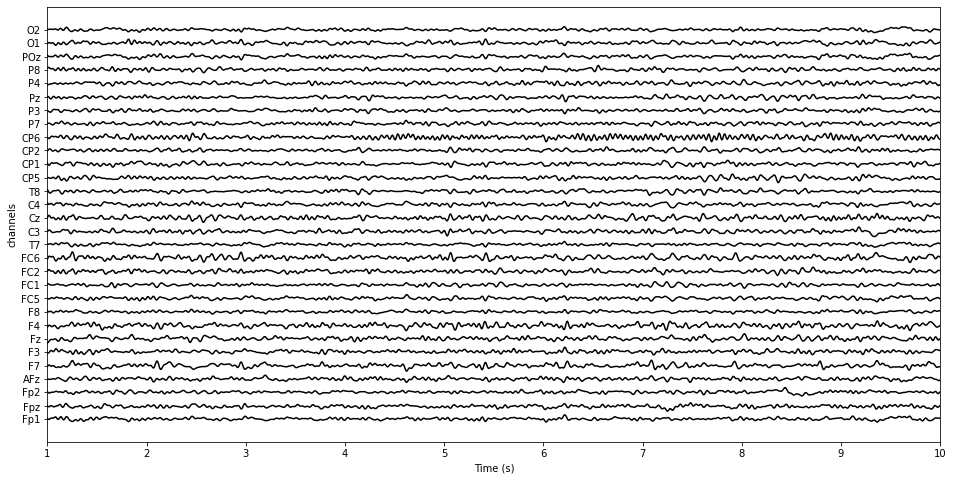

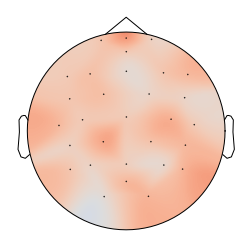

(30, 3)
sujeto: 8 estado de reposo: 1


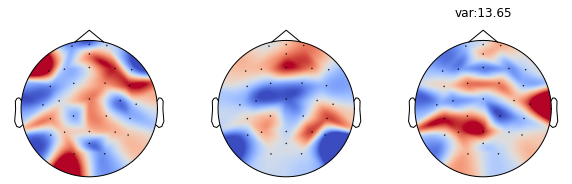

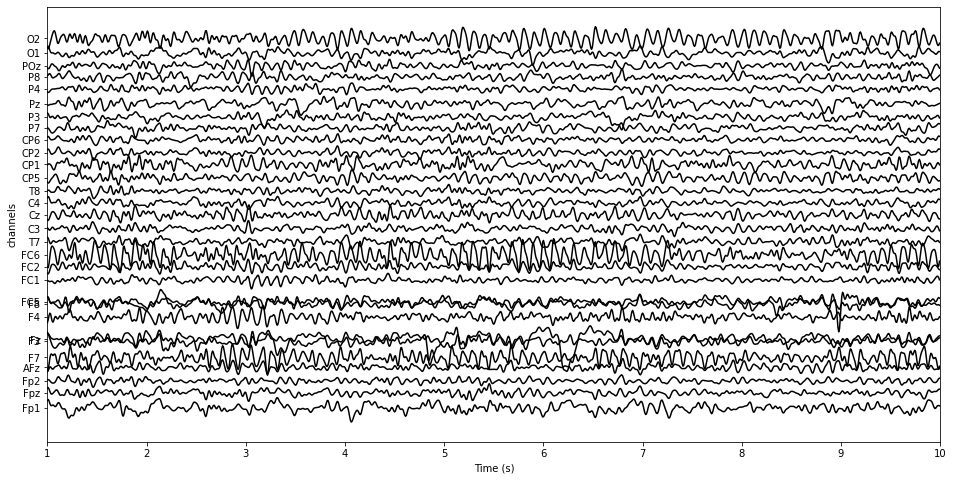

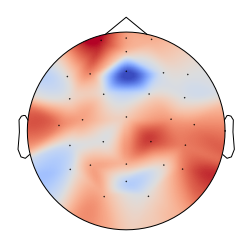

(30, 3)
sujeto: 8 estado de reposo: 2


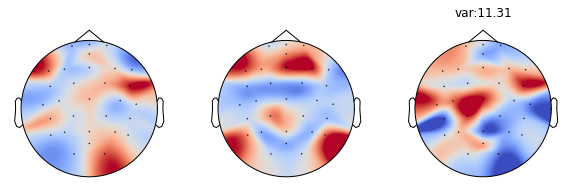

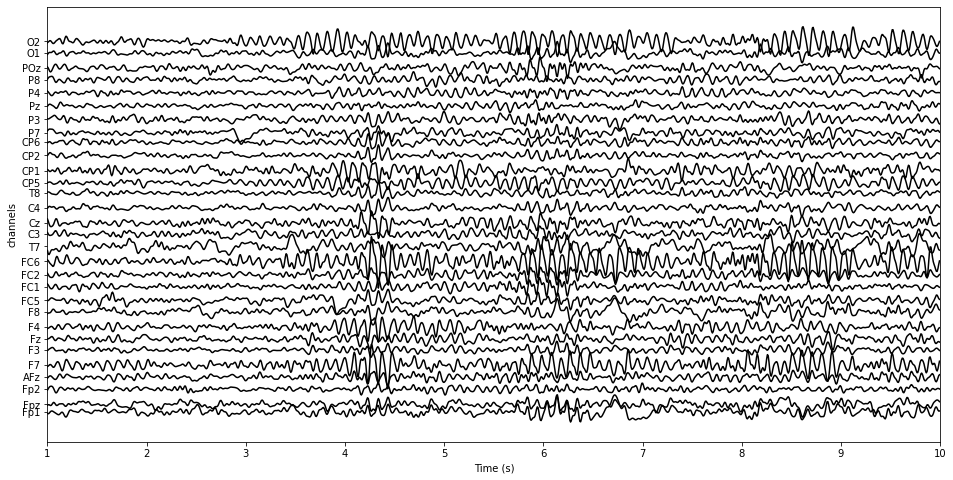

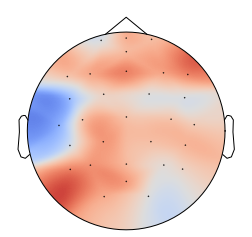

(30, 3)
sujeto: 9 estado de reposo: 1


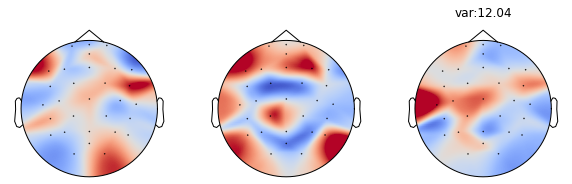

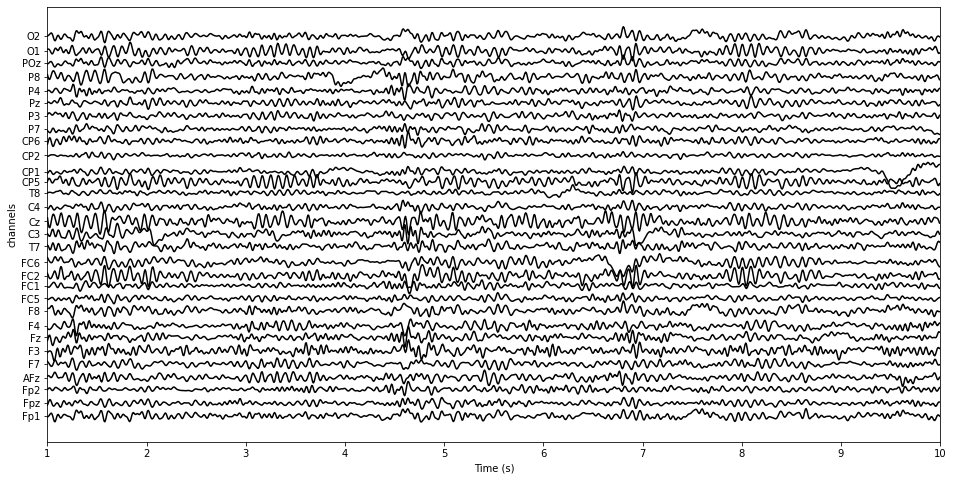

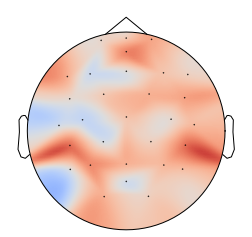

(30, 3)
sujeto: 9 estado de reposo: 2


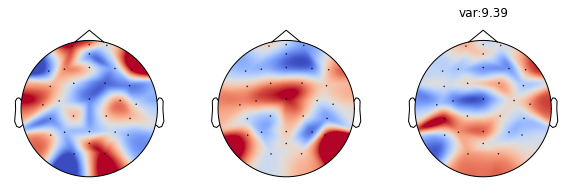

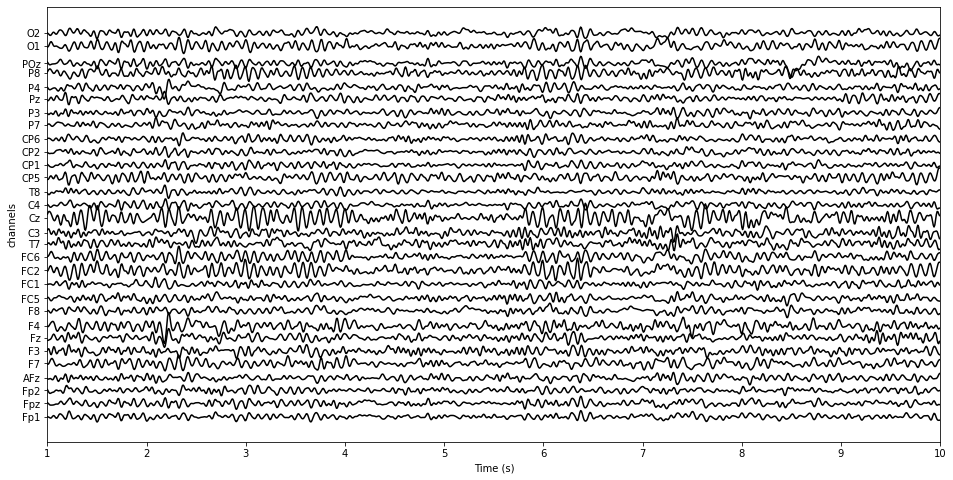

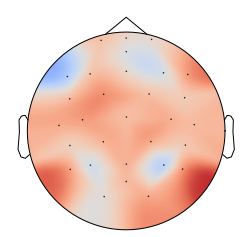

(30, 3)


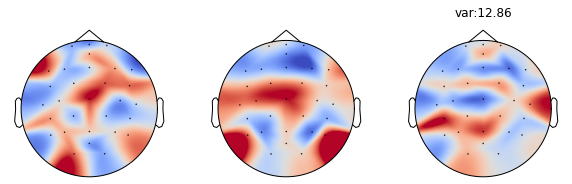

In [51]:
info_eeg, mont1020_30 = get_info_eeg_and_montage()
datos_orig            = np.empty((0,32))  #30 canales + 2 metadata individuo y tipo de reposo
promedios_totales     = np.empty((0,30))
inicio                = 1 #calcula los promedios entre 1 y 4
fin                   = 4

for eeg in sorted(eegs, key=lambda it: it.subject + it.resting_state):
    print("sujeto:", eeg.subject, "estado de reposo:", eeg.resting_state)

    participante = np.repeat(int(eeg.subject), eeg.nsamples).reshape(eeg.nsamples, 1)
    tipo       = np.repeat(int(eeg.resting_state), eeg.nsamples).reshape(eeg.nsamples, 1)    
    
    metadata   = np.concatenate((participante,tipo),axis=1)
    datos_orig = np.concatenate((datos_orig,np.concatenate((eeg.data, metadata),axis=1)),axis=0)

    promedios         = eeg.data[inicio*eeg.sfrequency:fin*eeg.sfrequency, :].mean(axis=0)
    promedios_totales = np.concatenate((promedios_totales, promedios.reshape(1,30)), axis=0) 

    plot_egg(eeg.dataT(), mont1020_30, eeg.sfrequency)
    plot_eeg_topology(promedios, info_eeg, -0.54932109, 0.34050091) #estos son los valores máximo y minimo de todos los promedios
    plot_eeg_pca(info_eeg, eeg.data)


In [52]:
print(promedios_totales.max(axis=None))
print(promedios_totales.min(axis=None))

0.34050090885416645
-0.5493210911458327


In [ ]:
datos_orig.shape

Los registros fueron tomados con el montage 10-20.

**La nariz es fpz**.
Tengo que armarlo que los electrodos tengan esta distribución:
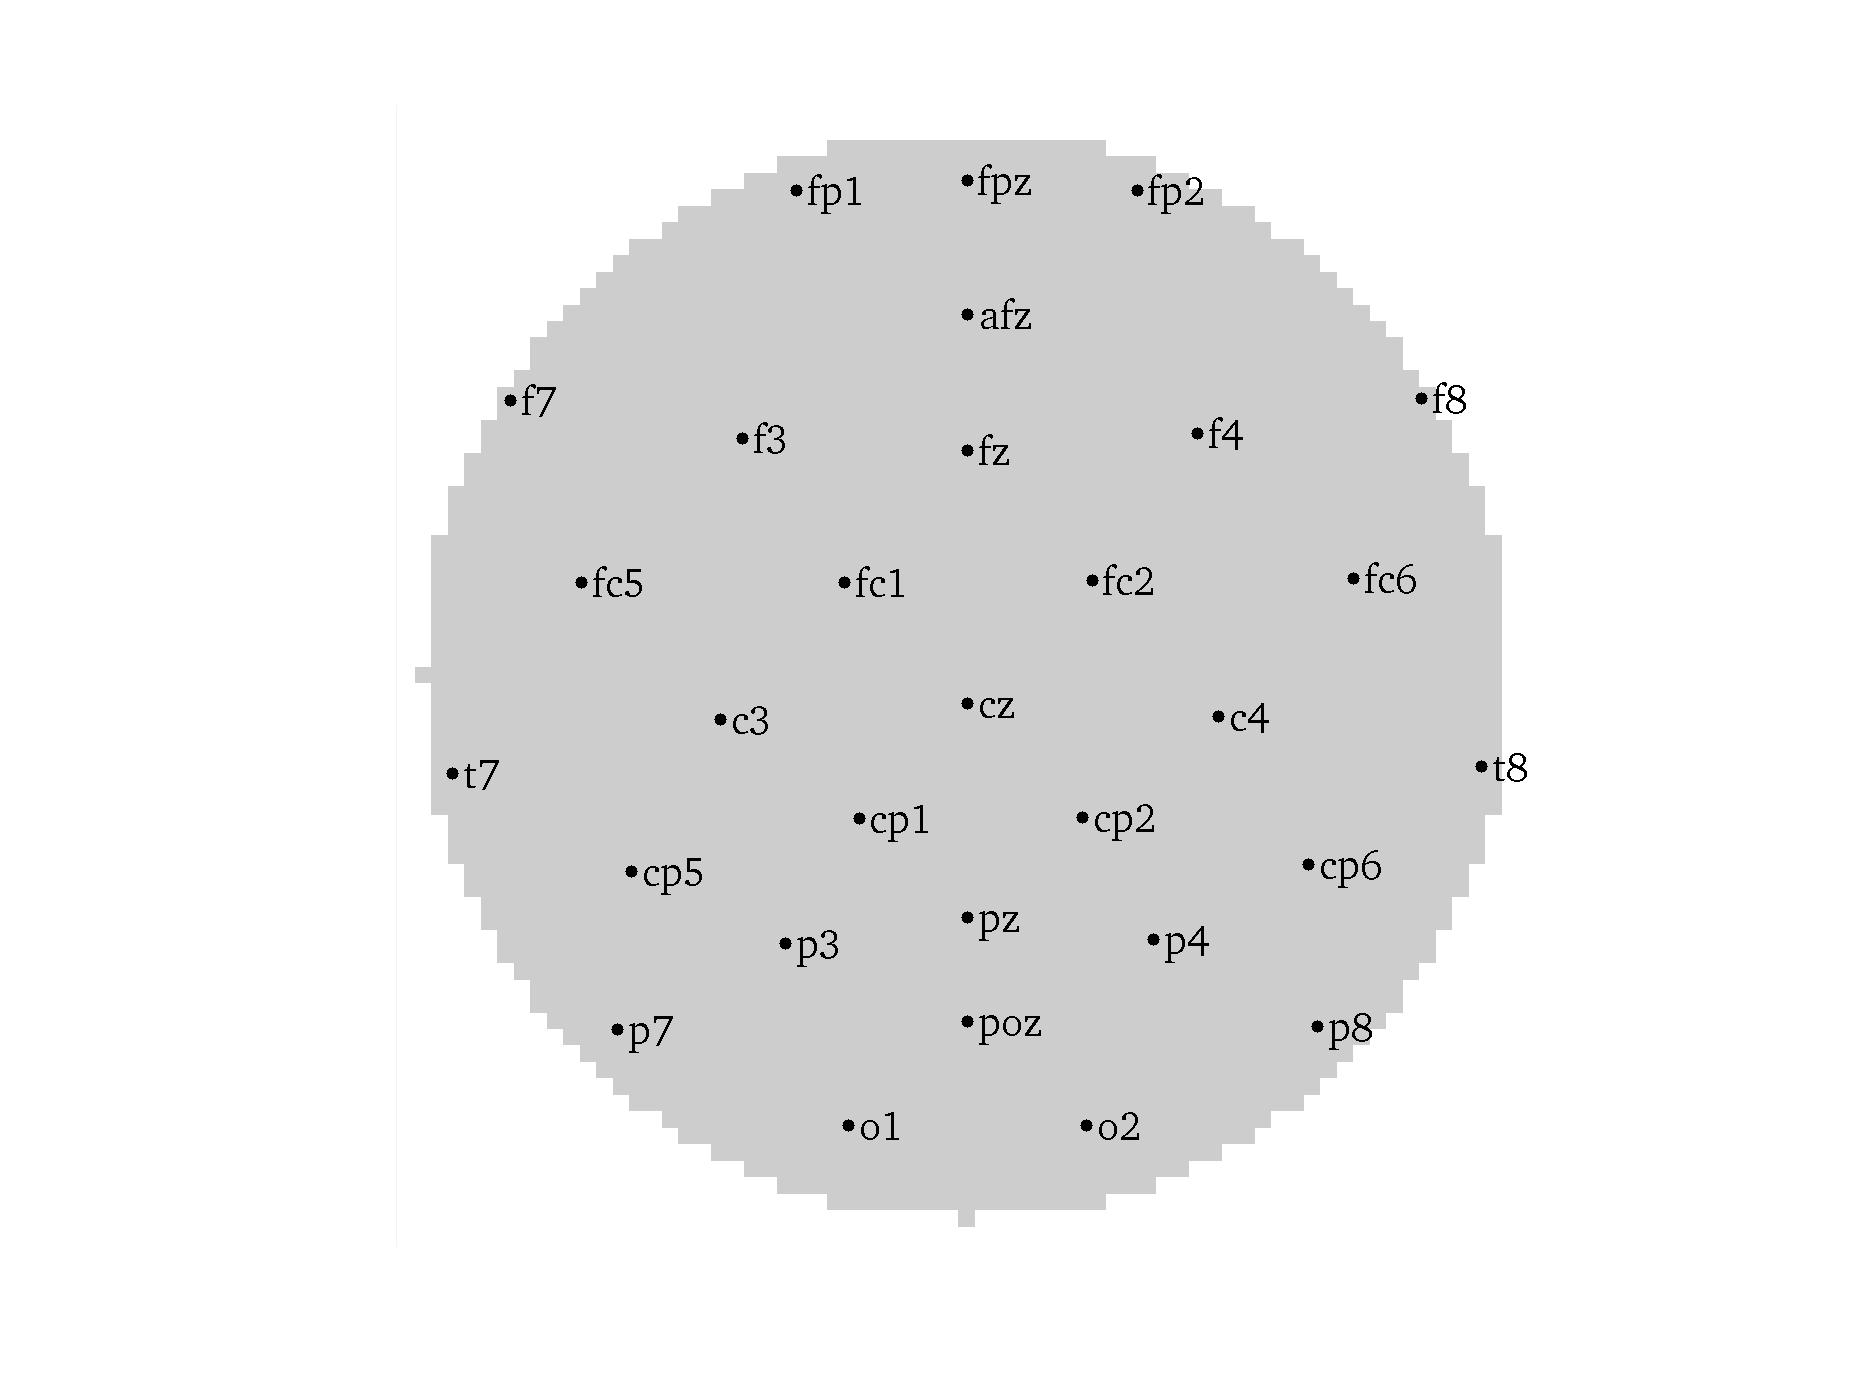

# 1.b - Inspección de los datos EEG procesados

Para los cálculos a continuación uso ref https://link.springer.com/content/pdf/10.1007/s10548-008-0054-5.pdf

In [ ]:
egg = eegs[1]

Siendo la media $\bar{u}=\frac{1}{c}\sum_{i=1}^{c}{U_{i}}$   donde $c$ es la cantidad total de canales y $U_{i}$ es la medición del i-ésimo canal.

Entonces el *average reference* se calcula $u_i=U_i-\bar{u}$

In [ ]:
u_mean = np.mean(egg.dataT(), axis=0)  # axis=0 calcula para cada n-esima muestra
u_mean.shape

In [ ]:
u_i = egg.dataT() - u_mean

De acuerdo a la referencia el *Global field power* (GFP) se calcula como 
$GFP(n)=\sqrt{\frac{1}{c}\sum_{i=1}^{c}u_{i}^2}$  y es equivalente al desvio estándar de los electrodos (en un cierto tiempo *t* o muestra *n*).

In [ ]:
GFP=np.sqrt(1/30*np.sum(u_i**2,axis=0))

In [ ]:
#sx_std=np.std(u_i,axis=0) # coincide con el cálculo de GFP como era previsible

In [ ]:
GFP=np.sqrt(1/30*np.sum(u_i**2,axis=0))

defino el tiempo

In [60]:
len(GFP)

7681

In [69]:
t = np.arange(0, 60.005, 1/egg.sfrequency)

In [62]:
len(t)

7681

Las otras figuras de sección previa están ploteadas entre 1 y 4 segundos. Sin embargo se tienen datos durante 60 segundos. La varianza obtenida se dibuja para el tiempo total. 

In [70]:
egg.sfrequency * 150 * 1e-3

19.2

Los picos de GCP se encuentran con la función find_peaks. Para evitar que estén demasiado próximos entre sí se elige el parámetro distancia.
Por ejemplo eligiendo distance=8 y con la frecuencia de muestreo de 128 Hz los picos deberán estar alejados en no menos de 60 ms (aproximadamente).

In [64]:
8/egg.sfrequency

0.0625

In [65]:
peaks, _ = find_peaks(GFP, height=0, prominence=1,distance=8)

valores mínimos y máximos entre picos consecutivos

In [66]:
print("Cantidad de picos de GCP:", len(peaks))
print("El intervalo temporal entre máximos de GCP promedio es:",60/len(peaks),'ms')
print("El intervalo temporal entre máximos de GCP más chico es:",min(np.diff(peaks))/128,'ms')
print("El intervalo temporal entre máximos de GCP más grande es:",max(np.diff(peaks))/128,'ms')

Cantidad de picos de GCP: 588
El intervalo temporal entre máximos de GCP promedio es: 0.10204081632653061 ms
El intervalo temporal entre máximos de GCP más chico es: 0.0625 ms
El intervalo temporal entre máximos de GCP más grande es: 0.234375 ms


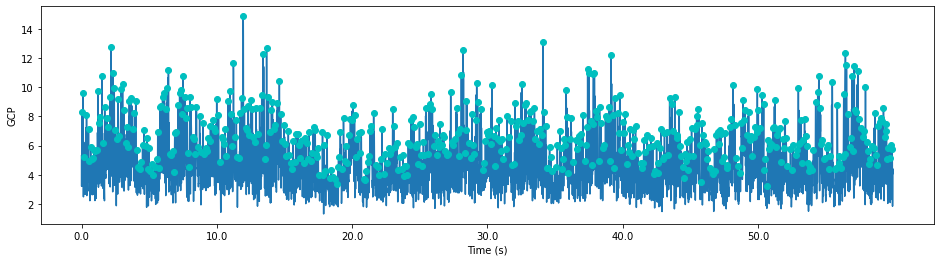

In [68]:
plot_GPF(GFP, peaks, t)

El remuestreo se hace con los indices determinados por los picos de GCP

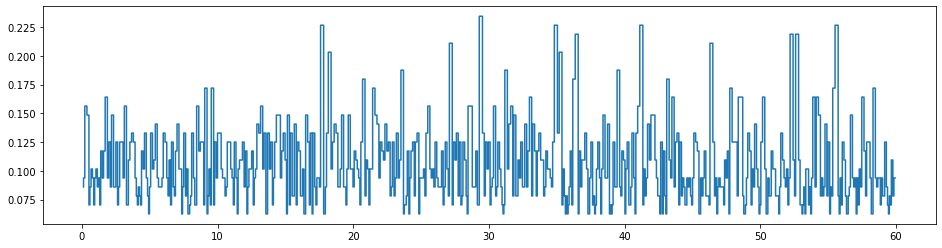

In [40]:
fig,ax=plt.subplots(ncols=1,figsize=(16,4))
plt.step(t[peaks[1:]],np.diff(t[peaks]))

Para cada indice identificados del máximo de GCP se calcula cuanto vale $u_{i}$.

In [73]:
data = np.transpose(u_i[:,peaks])
data.shape

(588, 30)

In [72]:
df = pd.DataFrame(data, columns=mont1020_30.ch_names)
df

Hago la misma descomposición de PCA, pero como en el dataframe quedaron en las columnas los nombres de los electrodos entonces primero aplico pca al dataset transpuesto (repito lo que hizo antes la profe).



PCS: (30, 3)


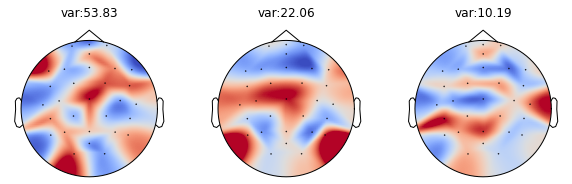

In [45]:
var = plot_df_pca(df, info_eeg)

In [46]:
var  # pca.explained_variance_ratio_

array([0.53825679, 0.22063786, 0.10193702])

In [47]:
print("las 3 primeras componentes explican un ",sum(var)*100,"% de la variabilidad")

las 3 primeras componentes explican un  86.08316609707761 % de la variabilidad


In [ ]:
#KMeans(n_clusters=6, random_state=0).fit(df)